<a href="https://colab.research.google.com/github/SolomonItany/Machine-Learning---Python/blob/main/Ride_sharing_Demand_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ride Sharing Demand Prediction



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime as dt


In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sampleSubmission = pd.read_csv("/content/sampleSubmission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


##Feature Engineering

In [ ]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['day_of_week'] = train['datetime'].dt.dayofweek  # Monday is 0 and Sunday is 6
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour

In [ ]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['day_of_week'] = test['datetime'].dt.dayofweek  # Monday is 0 and Sunday is 6
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour

In [ ]:
for column in train.columns:
    if column in ['casual', 'registered', 'datetime']:
        train.drop(column, axis=1, inplace=True)

for column in test.columns:
    if column in ['datetime']:
        test.drop(column, axis=1, inplace=True)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       10886 non-null  int64  
 1   holiday      10886 non-null  int64  
 2   workingday   10886 non-null  int64  
 3   weather      10886 non-null  int64  
 4   temp         10886 non-null  float64
 5   atemp        10886 non-null  float64
 6   humidity     10886 non-null  int64  
 7   windspeed    10886 non-null  float64
 8   count        10886 non-null  int64  
 9   day_of_week  10886 non-null  int64  
 10  year         10886 non-null  int64  
 11  month        10886 non-null  int64  
 12  hour         10886 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 1.1 MB


array([[<Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'hour'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

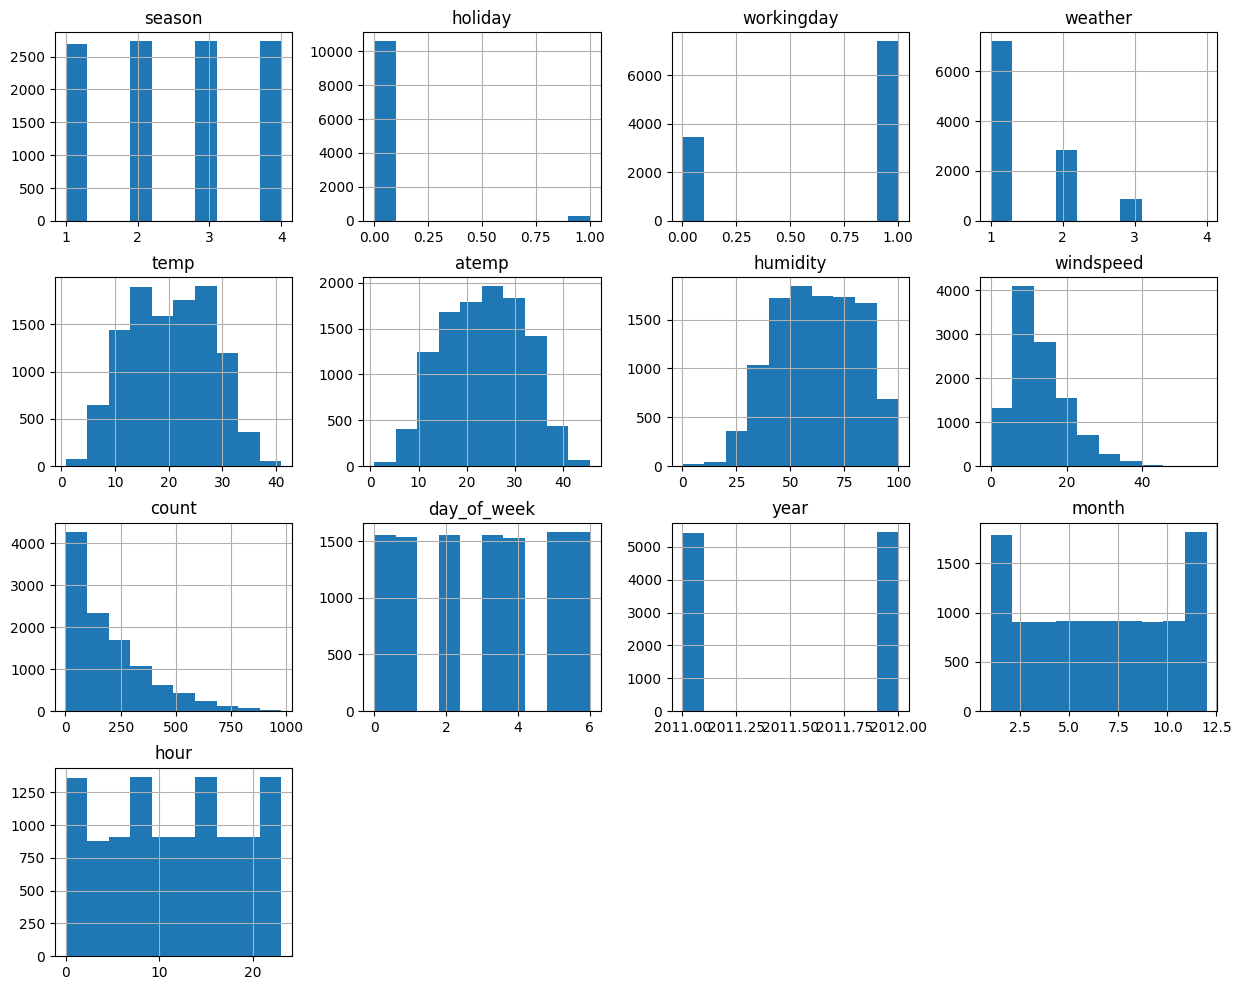

In [ ]:
train.hist(figsize=(15, 12))

In [ ]:
train['windspeed']= np.log(train['windspeed'] + 1)
test['windspeed']= np.log(test['windspeed'] + 1)

<Axes: >

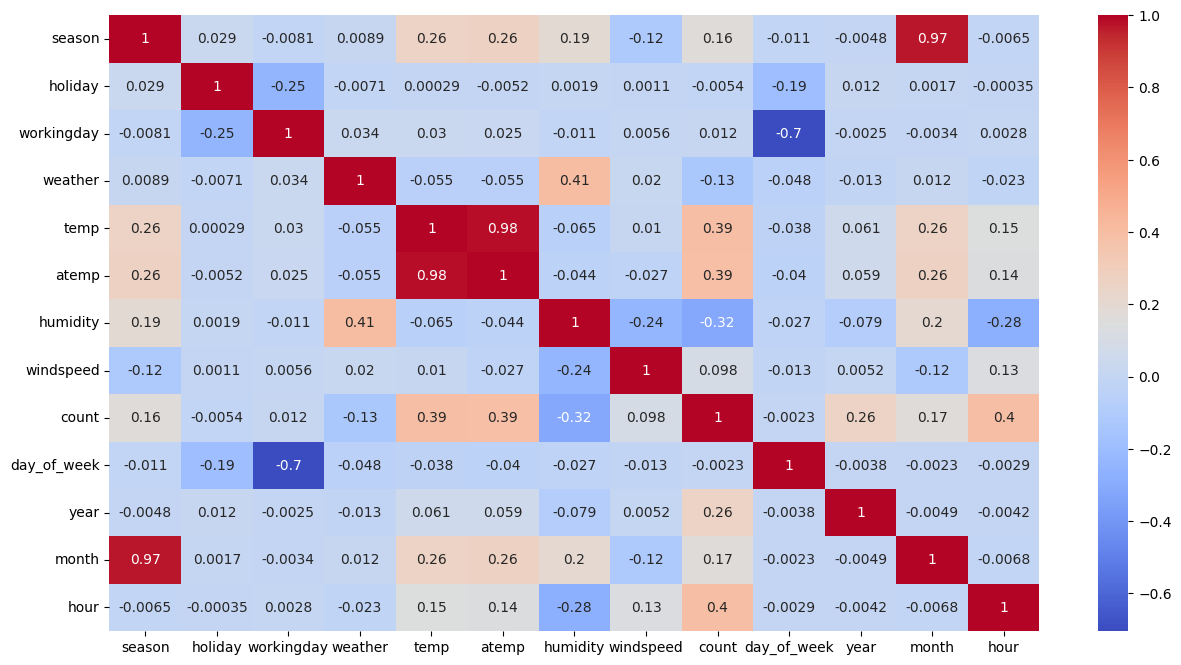

In [ ]:
plt.figure(figsize=(15, 8))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [ ]:
X=train.drop('count', axis=1)
y=train['count']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [ ]:
test_scaled =  scaler.transform(test)

##Modelling

## cost function ---Root Mean Squared Logarithmic Error (RMSLE)

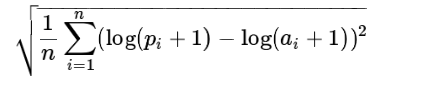

In [ ]:
def rmsle(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

In [ ]:
# Simple linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
pred_train = reg.predict(X_train)
pred_val = reg.predict(X_val)
rmsle_train = rmsle(y_train, pred_train)
rmsle_val = rmsle(y_val, pred_val)
print(f'The training rmsle is: {rmsle_train}')
print(f'The  validation rmsle is: {rmsle_val}')

The training rmsle is: 1.2956032472026962
The  validation rmsle is: 1.3258077339308625


In [ ]:
# Stocastic Gradient decent Regressor
sdgreg = SGDRegressor()
sdgreg.fit(X_train_scaled, y_train)

pred_train = sdgreg.predict(X_train_scaled)
pred_val = sdgreg.predict(X_val_scaled)

rmsle_train = rmsle(y_train, pred_train)
rmsle_val = rmsle(y_val, pred_val)
print(f'The training rmsle is: {rmsle_train}')
print(f'The  validation rmsle is: {rmsle_val}')


The training rmsle is: 1.2900417730333285
The  validation rmsle is: 1.3239236960469547


In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)

pred_train = ridge.predict(X_train)
pred_val = ridge.predict(X_val)

rmsle_train = rmsle(y_train, pred_train)
rmsle_val = rmsle(y_val, pred_val)

print(f'The training rmsle is: {rmsle_train}')
print(f'The validation rmsle is: {rmsle_val}')

The training rmsle is: 1.295534004747572
The validation rmsle is: 1.3257483781495691


In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators = 200)
rf.fit(X_train_scaled, y_train)

pred_train = rf.predict(X_train_scaled)
pred_val = rf.predict(X_val_scaled)

rmsle_train = rmsle(y_train, pred_train)
rmsle_val = rmsle(y_val, pred_val)

print(f'The training RMSLE is: {rmsle_train}')
print(f'The validation RMSLE is: {rmsle_val}')

The training RMSLE is: 0.14755481739822116
The validation RMSLE is: 0.3516993453844284


In [ ]:
#XGBoost
xgb_reg = XGBRegressor()  # You can adjust hyperparameters as needed

# Train the model
xgb_reg.fit(X_train, y_train)

# Make predictions
pred_train = xgb_reg.predict(X_train)
pred_val = xgb_reg.predict(X_val)

rmsle_train = rmsle(y_train, pred_train)
rmsle_val = rmsle(y_val, pred_val)

print(f'The training RMSLE is: {rmsle_train}')
print(f'The validation RMSLE is: {rmsle_val}')

The training RMSLE is: 0.354259539315659
The validation RMSLE is: 0.5232660743744166


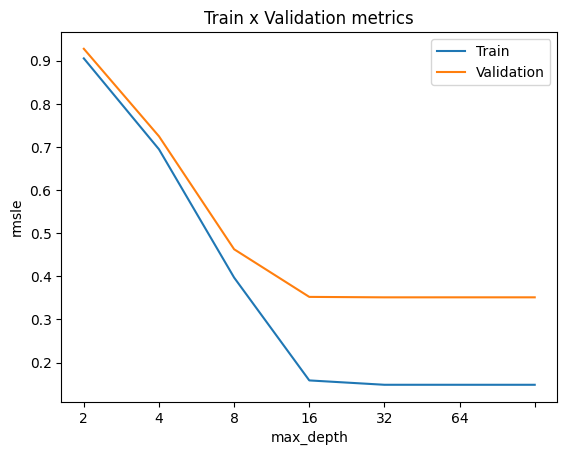

In [ ]:
max_depth_list = [2, 4, 8, 16, 32, 64, None] ## 32
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    rf = RandomForestRegressor(max_depth = max_depth,
                                   random_state = 201).fit(X_train_scaled,y_train)
    pred_train = rf.predict(X_train_scaled)
    pred_val = rf.predict(X_val_scaled)
    rmsle_train = rmsle(y_train, pred_train)
    rmsle_val = rmsle(y_val, pred_val)
    accuracy_list_train.append(rmsle_train )
    accuracy_list_val.append(rmsle_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('rmsle')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

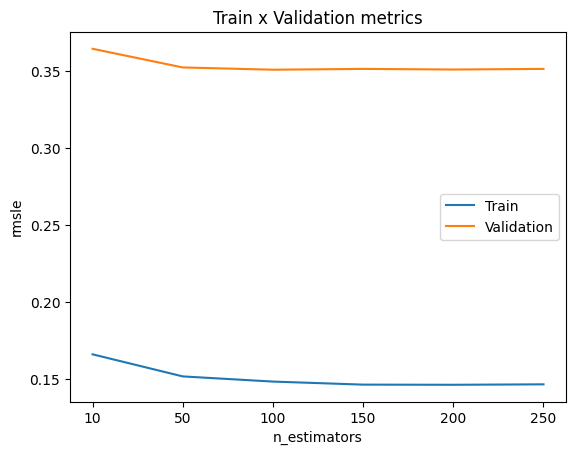

In [ ]:
n_estimators_list = [10,50,100,150, 200,250] ## 200

accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    rf = RandomForestRegressor(n_estimators = n_estimators,
                                   random_state = 201).fit(X_train_scaled,y_train)
    pred_train = rf.predict(X_train_scaled)
    pred_val = rf.predict(X_val_scaled)
    rmsle_train = rmsle(y_train, pred_train)
    rmsle_val = rmsle(y_val, pred_val)
    accuracy_list_train.append(rmsle_train )
    accuracy_list_val.append(rmsle_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('rmsle')
plt.xticks(ticks = range(len(n_estimators_list)),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

##Final model

In [ ]:
Model = RandomForestRegressor(n_estimators = 200, max_depth=32)
Model.fit(X_train_scaled, y_train)

pred_train = Model.predict(X_train_scaled)
pred_val = Model.predict(X_val_scaled)

rmsle_train = rmsle(y_train, pred_train)
rmsle_val = rmsle(y_val, pred_val)

print(f'The training RMSLE is: {rmsle_train}')
print(f'The validation RMSLE is: {rmsle_val}')

The training RMSLE is: 0.14726412931720315
The validation RMSLE is: 0.3520345090067482


In [ ]:
Finalpred = Model.predict(test_scaled)

In [ ]:
sampleSubmission['count'] = Finalpred

In [ ]:
sampleSubmission['datetime'] = pd.to_datetime(sampleSubmission['datetime'])

In [ ]:
sampleSubmission.head(5)

,datetime,count
0,2011-01-20 00:00:00,10.495
1,2011-01-20 01:00:00,5.960
2,2011-01-20 02:00:00,5.580
3,2011-01-20 03:00:00,3.880
4,2011-01-20 04:00:00,2.810


In [ ]:
sampleSubmission.to_csv('sample_submission.csv', index=False)